<a href="https://colab.research.google.com/github/BakhtawarRehman/Facial-Emotion-Recognition/blob/master/MaskRcNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MASK-RCNN was proposed in 2017. It is build on faster-rcnn. The mask in the name implies to mask creation or instance segmentation.
1st part is a **backbone model** i.e a resnet50 or resnet101 model to extract features. Than it uses two **Feature Pyramid Networks (FPN)** - 2 because the first pyramid passes high-level features down to the second oyramid; this way it can have acces to both high and low lwvel features. Than it uses **Region Proposal Network**; which uses 200k anchors of different sizes and aspect ratio to find the object inside it. If an anchor box is associated with any object the anchor box may adjust lolocate the object beter. ROI and Bounding box is generated. Than ROiPooling is applied (cropping and resing of dettected object). And lastly segmentation mask is applied. 

To implement this, i am going to  import 

In [2]:
#Importing matterport's mask-rcnn 
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 45.72 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [3]:
%cd /content/Mask_RCNN/
!sudo python setup.py install

/content/Mask_RCNN
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.

In [4]:
#Embedding gDrive to load data from.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Importing libraries and defining classes 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
 
# define 81 classes that the coco model knowns about
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


In [11]:
# define the test configuration
class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 80


config = TestConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
# Declaring function to prcess image for applying mask.
def showMask(weight, img):
  # define the model
  rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())
  # load coco model weights
  rcnn.load_weights(weight, by_name=True)
  # load photograph
  img = load_img(img)
  img = img_to_array(img)
  # make prediction
  results = rcnn.detect([img], verbose=0)
  # get dictionary for first prediction
  r = results[0]
  # show photo with bounding boxes, masks, class labels and scores
  display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

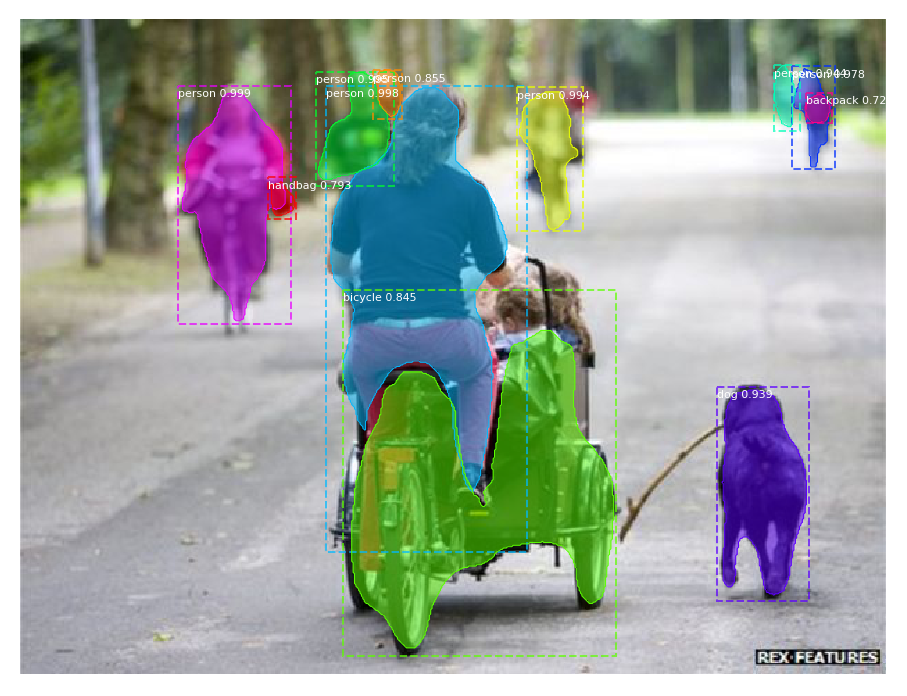

In [12]:
showMask('/content/drive/My Drive/mask_rcnn_coco.h5', '/content/2.jpg')

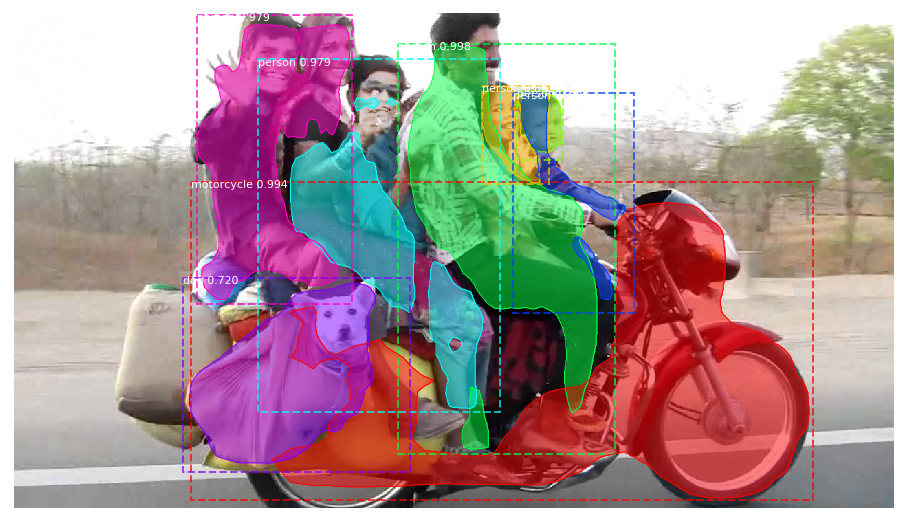

In [13]:
# This is an interesting image because all the object dettection methods (I know of) missed an object or 2.
#Mask-rcnn is better than yolo and ssd on this image. It has detected 5 persons (6 total); dog and bike.
showMask('/content/drive/My Drive/mask_rcnn_coco.h5', '/content/3.jpg')